In [1]:
import numpy as np

In [2]:
import lhapdf

In [3]:
lhapdf.pathsPrepend('/home/sam/miniconda3/pkgs/share/LHAPDF') # sorry, this is specific to my computer!!
print(lhapdf.paths())

['/home/sam/miniconda3/pkgs/share/LHAPDF', '/home/sam/anaconda3/pkgs/share/LHAPDF', '/home/sam/anaconda3/pkgs/share/LHAPDF']


```python
"""This returns u(x)*x"""
p = lhapdf.mkPDF("CT18NNLO", 0) # or whatever model we want to use.

xs = [x for x in np.logspace(-7, 0, 5)]
qs = [q for q in np.logspace(1, 4, 4)]
ux_xfs = np.empty([len(xs), len(qs)])
for ix, x in enumerate(xs):
    for iq, q in enumerate(qs):
        ux_xfs[ix,iq] = p.xfxQ(2, x, q) # flavor table: 2 -> up quark.
        # could also make this in terms of q^2 for higher efficiency.
print(np.shape(ux_xfs))
```

> ### Let's generalize this to a function!

In [4]:
q_dict = {"tbar":-6,"bbar":-5,"cbar":-4,"sbar":-3,"ubar":-2,"dbar":-1,
          "g":0,
          "d":1,"u":2,"s":3,"c":4,"b":5,"t":6}

In [5]:
"""Need to feed arrays xs and qs!"""
def fx_x(pdf_set, quark_name, xs, qs):
    p     = lhapdf.mkPDF(pdf_set, 0) # or whatever model we want to use.
    quark = q_dict[quark_name]       # get associated quark number.
    
#     xs = [x for x in np.logspace(-7, 0, 5)]
#     qs = [q for q in np.logspace(1, 4, 4)]
    x_xfs = np.empty([len(xs), len(qs)])
    for ix, x in enumerate(xs):
        for iq, q in enumerate(qs):
            x_xfs[ix,iq] = p.xfxQ(quark, x, q) # flavor table: 2 -> up quark.
            # could also make this in terms of q^2 for higher efficiency.
#     print(np.shape(x_xfs))
    return x_xfs     # returns f(x)*x for quark f.

In [6]:
fx_x("CT18NNLO","dbar",xs=[0.1],qs=[0.1,0.2]) # looks like it's working, the shape is interesting?

array([[0.00088526, 0.00376125]])

In [8]:
fx_x("cteq66","dbar",xs=[0.1],qs=[0.1,0.2])

array([[0.00086526, 0.00367161]])

In [9]:
a         = 1/137    # fine structure constant.
prefactor = 4*np.pi*(a)**2
m_p       = 0.938    # mass of proton in GeV?

In [10]:
"""Takes array of x and y values. 
Outputs corresponding array of q**2's."""
def q2f(E,xs,ys):
#     return 2*m_p * E * x * y
    q2 = np.empty([len(xs), len(ys)])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            q2[ix,iy] = 2*m_p*E*x*y
    return q2

In [11]:
q2f(10, [0.1],[0.1,0.2,0.3])

array([[0.1876, 0.3752, 0.5628]])

$$\begin{align} \frac{F_2^{ep}(x)}{x} &= \frac{4}{9}(u(x)+\bar{u}(x))+\frac{1}{9}(d(x)+\bar{d}(x))+\frac{1}{9}(s(x)+\bar{s}(x))+ ... \end{align}$$

$$\begin{align} F_1(x) = \left\{
        \begin{array}{ll}
            0 & \quad \textrm{spin-zero partons} \\
            \left(\frac{1}{2x}\right)F_2(x) & \quad \textrm{spin-$\frac{1}{2}$ partons}
        \end{array}
    \right.\end{align}$$

In [12]:
def F2_ep(pdf_set, x, y):
    series = (4/9)*(fx_x(pdf_set,"u",x,y) + fx_x(pdf_set,"ubar",x,y)) +\
             (1/9)*(fx_x(pdf_set,"d",x,y) + fx_x(pdf_set,"dbar",x,y)) +\
             (1/9)*(fx_x(pdf_set,"s",x,y) + fx_x(pdf_set,"sbar",x,y)) +\
             (1/9)*(fx_x(pdf_set,"c",x,y) + fx_x(pdf_set,"cbar",x,y)) +\
             (1/9)*(fx_x(pdf_set,"t",x,y) + fx_x(pdf_set,"tbar",x,y)) +\
             (1/9)*(fx_x(pdf_set,"b",x,y) + fx_x(pdf_set,"bbar",x,y)) 
    return series

In [13]:
F2_ep("CT18NNLO", [0.1,0.2,0.3], [0.1,0.2])

array([[0.00249229, 0.01055733],
       [0.00254206, 0.01083509],
       [0.00221989, 0.00950597]])

In [52]:
"""Assume x,y array inputs. Return F2."""
"""I JUST CHANGED y to q!!!"""
def F1_ep(pdf_set,x,q):
#     return (1/(2*x))*F2_ep(pdf_set,x,y)
    f1 = F2_ep(pdf_set,x,q)
    for ix, x in enumerate(x):
        f1[ix] *= (1/(2*x))
    return f1
    # aren't all the spins of the series in F2_ep() spin-1/2?

In [15]:
F1_ep("CT18NNLO", [0.1,0.2,0.3], [0.1,0.2])

array([[0.01246147, 0.05278663],
       [0.00635515, 0.02708772],
       [0.00369982, 0.01584328]])

In [16]:
# Does F2_ep need to explicitly depend on x? Is the fx_x for a specific case right now?
def functional(pdf_set,xs,ys):
#     return (F2_ep(pdf_set,x,y)*(1-y) + F1_ep(pdf_set,x,y)*pow(y,2)*x)

    # this is a silly way to implement this, 
    # but I need to somehow tame the array when isolating a single value.
    qs = q2f(E,x,y) # this needs to be taken into account. q's need to go in rather than y's in certain spots.
    
    
    left = np.empty([len(xs), len(ys)])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            left[ix,iy] = (1-y)
    right = np.empty([len(xs), len(ys)])
    for ix, x in enumerate(xs):
        for iy, y in enumerate(ys):
            left[ix,iy] = pow(y,2)*x
            
    return (F2_ep(pdf_set,xs,qs)*left + F1_ep(pdf_set,xs,qs)*right)

In [17]:
functional("CT18NNLO", [0.1,0.2,0.3], [0.1,0.2]) # this DOES output something...

array([[1.57780538e-04, 2.82865797e-03],
       [4.54720945e-05, 8.20425469e-04],
       [2.03483552e-05, 3.65081301e-04]])

$$\begin{align} \frac{d^2\sigma}{dxdy} &= \frac{4\pi \alpha^2 s}{Q^4}[F_2(x)(1-y)+F_1(x)xy^2]\end{align}$$

In [18]:
def cross_section(E,x,y,pdf_set):
    s = m_p**2 + 2*E * m_p # invariant mass.
    
    cs = prefactor * s / q2f(E,x,y)**2 * functional(pdf_set,x,y)
    return cs

In [19]:
E = 10        # incident electron beam energy in GeV.
cross_section(E,x=np.logspace(-5,0,5),y=np.logspace(-5,0,3),pdf_set="CT18NNLO") / E     
# make sure units are consistent.

array([[1.46229708e-11, 1.46232185e-06, 1.57357629e-01],
       [7.09086349e-13, 7.09111961e-08, 8.28379314e-03],
       [2.88483426e-14, 2.88496877e-09, 3.52560527e-04],
       [1.53003001e-15, 1.53012903e-10, 2.02097974e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Take same x and y ~ q^2 (Eq. 2) range as Huma's data for comparison.

For a given value of x, we vary over y. Reproduce F1 and F2 values. Then get cross section.

In [20]:
import matplotlib.pyplot as plt

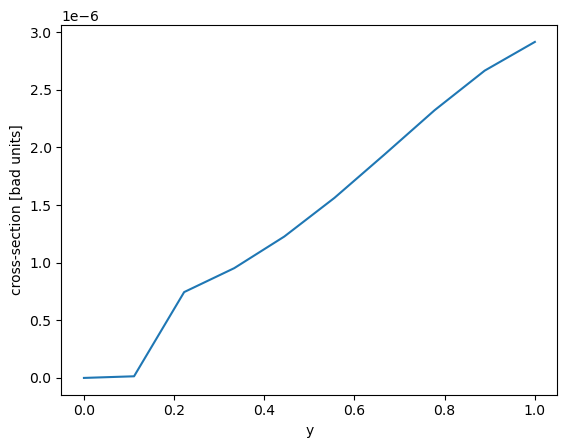

In [21]:
plt.figure()

E = 10        # incident electron beam energy in GeV.
y = np.linspace(1e-5,1,10)
cs = cross_section(E,x=[0.45],y=y,pdf_set="CT18NNLO") / E    
plt.plot(y,cs[0])
plt.xlabel('y')
plt.ylabel('cross-section [bad units]')
plt.show()

In [22]:
# if you want to generate Huma results for a fixed value of E and a given x (this corresponds to the first 20 lines)
x=0.05
E=3.0
ny=19
mp=0.938
y=np.zeros(ny)
y=np.linspace(0.05,0.95,ny)
print(y)
q2=np.zeros(ny)
q2=2.0*mp*E*x*y
print(q2)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
[0.01407 0.02814 0.04221 0.05628 0.07035 0.08442 0.09849 0.11256 0.12663
 0.1407  0.15477 0.16884 0.18291 0.19698 0.21105 0.22512 0.23919 0.25326
 0.26733]


In [48]:
#if you want to generate the full table Huma sent for a fixed value of E
nx=19
x=np.zeros(nx)
x=np.linspace(0.05,0.95,nx)
E=3.0
ny=19
mp=0.938
y=np.zeros(ny)
y=np.linspace(0.05,0.95,ny)
q2=np.zeros((nx,ny))
for i in range (nx):
    q2[i,:]=2.0*mp*E*x[i]*y
# print(q2)

In [24]:
#if you want to generate the full table Huma sent for a fixed value of E
nx=19
E=3.0
ny=19

# cross_section(E,x=np.linspace(0.05,0.95,nx),y=np.linspace(0.05,0.95,ny),pdf_set="CT18NNLO") / E  

In [25]:
q2f(3,[0.55],[0.35]) # this works pretty closely!

array([[1.08339]])

In [26]:
F2_ep("CT18NNLO", [0.55],[0.35]) # quite some disagreement? 0.124 vs 0.154

array([[0.01242411]])

In [27]:
F1_ep("CT18NNLO", [0.55],[0.35]) # again? 0.113 vs 0.149

array([[0.01129465]])

In [36]:
E  = 3.0
cs = cross_section(E,[0.55],[0.35],"CT18NNLO")

d0 = 1 # idk what to do with this one?
gevtocm=0.19733*d0**2*1e-26
d2sig = [0.55]*cs*gevtocm*1e+32/E

print(d2sig)

[[0.23805393]]


In [39]:
def conversion(E,cs):
    gevtocm=0.19733*2*1e-26 # extra factor of 2 hiding in here???
    d2sig = cs*gevtocm*1e+32/E
    return d2sig # double check this soon.

In [55]:
E  = 3.0
x  = [0.55]
y  = [0.35]

cs = cross_section(E,x,y,"CT18NNLO")
conversion(E,cs)

cs = cross_section(E,x,y,"cteq66")
print(conversion(E,cs))

q2s = q2f(E,x,y)
print(y,q2s)

print(F1_ep("cteq66",x,q2s)) # these are way too low? :(
print(F2_ep("cteq66",x,q2s))

[[0.42103925]]
[0.35] [[1.08339]]
[[0.11421888]]
[[0.12564077]]


GeV  q^2   x   y   f1  f2  d2sigma     

In [31]:
[3.0,1.08369,0.55,0.35,0.1499,0.1541539,0.42096] # benchmark for 3 GeV and associated values.

[3.0, 1.08369, 0.55, 0.35, 0.1499, 0.1541539, 0.42096]

In [32]:
E=3.0
nx=19
ny=19

x=np.linspace(0.05,0.95,nx);y=np.linspace(0.05,0.95,ny)
cs = cross_section(E,x,y,"CT18NNLO")
# conversion(E,cs)